In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import requests
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import hvplot.pandas
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Import SKLearn Library and Classes
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [3]:
#set path to Features CSV and read in CSV
aapl_df = pd.read_pickle('Resources/aapl_features_df.pickle')
aapl_df.tail()

,aapl Close,aapl Volume,Call Volume,Put Volume,Total Option Volume,Percent of Puts,Put signals,Percent of calls,Call signals,bollinger_mid_band,...,rvol SD,rvol signal,Option rVol,Option rVol SD,Option rVol signal,daily returns,sent_by_sentence_score,sentiment neg,sentiment pos,sentiment score
2019-12-23,283.9700,18737610,378735.0,199064.0,577799.0,0.344521,False,0.655479,True,271.174995,...,1.237881,0.0,1.046131,1.237881,0.0,0.016793,0.0000,0,0,0
2019-12-24,284.2762,9678447,158712.0,91650.0,250362.0,0.366070,False,0.633930,True,272.067805,...,1.233808,0.0,0.457942,1.233808,0.0,0.001078,0.7900,0,1,1
2019-12-26,289.9100,20772521,481923.0,275196.0,757119.0,0.363478,False,0.636522,True,273.358305,...,1.242775,0.0,1.327287,1.242775,0.0,0.019818,0.3612,0,1,1
2019-12-27,289.8300,32927275,793293.0,403309.0,1196602.0,0.337045,False,0.662955,True,274.454810,...,1.282726,1.0,1.949724,1.282726,1.0,-0.000276,0.8079,0,1,1
2019-12-30,291.6470,33920736,535826.0,287151.0,822977.0,0.348917,False,0.651083,True,275.678160,...,1.318722,1.0,1.285163,1.318722,1.0,0.006269,-0.6597,-1,0,-1


In [4]:
#Create new trading signals Df, 
trading_signals_df = pd.DataFrame()

In [5]:
#create features only dataframe by shifting feature signal, select features as x_var_list (for selling OTM puts, bollinger = bollinger short)

x_var_list = ['bollinger_short', 'rvol signal', 'Option rVol signal', 'sentiment neg']

trading_signals_df[x_var_list] = aapl_df[x_var_list].shift(1)

trading_signals_df = trading_signals_df.set_index(pd.to_datetime(aapl_df.index, infer_datetime_format=True))
trading_signals_df.head()

,bollinger_short,rvol signal,Option rVol signal,sentiment neg
2019-08-05,NaN,NaN,NaN,NaN
2019-08-06,0.0,1.0,1.0,-1.0
2019-08-07,0.0,1.0,1.0,0.0
2019-08-08,0.0,0.0,0.0,0.0
2019-08-09,0.0,0.0,0.0,-1.0


In [6]:
#add dependent variable for targeting a positive return, shift forward looking window by user defined amount
shift = 7
threshold = 0
trading_signals_df['Positive Return'] = np.where(aapl_df['daily returns'].shift(-shift)> threshold, 1, 0)

In [7]:
#drop Na and reduce df by shift amount
trading_signals_df = trading_signals_df.dropna()
trading_signals_df = trading_signals_df[:-shift]
trading_signals_df.tail()

,bollinger_short,rvol signal,Option rVol signal,sentiment neg,Positive Return
2019-12-12,-1.0,0.0,0.0,0.0,1
2019-12-13,-1.0,1.0,1.0,0.0,1
2019-12-16,-1.0,1.0,1.0,0.0,1
2019-12-17,-1.0,1.0,1.0,-1.0,0
2019-12-18,-1.0,1.0,1.0,-1.0,1


In [8]:
# Manually splitting the data
split = int(0.7 * len(trading_signals_df))

X_train = trading_signals_df.iloc[: split, :-1]
X_test = trading_signals_df.iloc[split:, :-1]

y_train = trading_signals_df['Positive Return'][:split]
y_test = trading_signals_df['Positive Return'][split:]


In [9]:
#Train Random Forest Model
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

In [10]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["RF Predicted Value"] = predictions
Results['Forward Daily Returns'] = aapl_df['daily returns'].shift(-shift)
Results

,Positive Return,RF Predicted Value,Forward Daily Returns
2019-11-13,0,0,-0.000649
2019-11-14,1,1,0.017492
2019-11-15,0,0,-0.008708
2019-11-18,1,1,0.014388
2019-11-19,0,0,-0.002687
2019-11-20,0,0,-0.011565
2019-11-21,0,1,-0.017305
2019-11-22,1,1,0.008554
2019-11-25,1,0,0.014671
2019-11-26,1,0,0.019279


In [11]:
Results['RF Predicted Value'].to_pickle(r'C:\Users\Kiel\Desktop\FINTECH\UCB_fintech_homework\project_2 - local\Resources\aapl_RF_signals_df.pickle')

<AxesSubplot:>

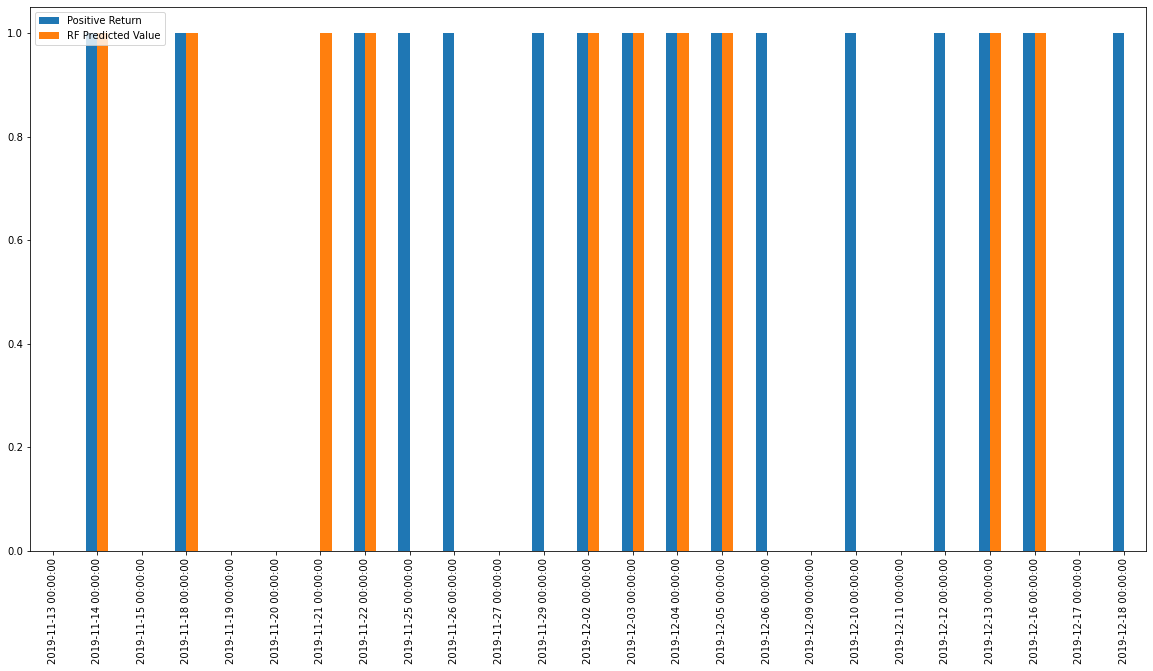

In [12]:
Results[['Positive Return', 'RF Predicted Value']].plot(figsize=(20,10), kind = 'bar')

<AxesSubplot:>

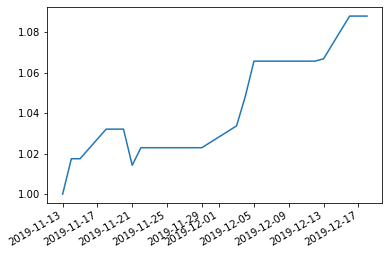

In [13]:
# Calculate cumulative return of model and plot the result
(1 + (Results['Forward Daily Returns'] * Results['RF Predicted Value'])).cumprod().plot()

<AxesSubplot:>

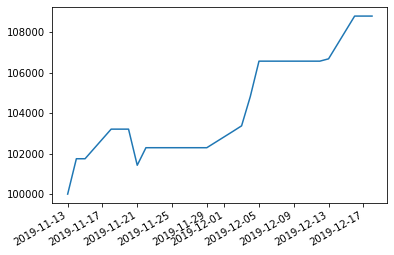

In [14]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (Results['Forward Daily Returns'] * Results['RF Predicted Value'])).cumprod()
cumulative_return_capital.plot()